In [7]:
import pandas as pd
import numpy as np
%matplotlib inline

In [8]:
olympics = pd.read_csv('athlete_events.csv')

In [9]:
olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [10]:
olympics.shape

(271116, 15)

### Data exploration and Basic Hygiene

Missing Values

In [11]:
olympics.isnull().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

 Height, weight and age have a lot of missing values. Medals have a NaN in 2,31,333 rows, since not all participating athletes would win medals. Replacing these missing values with 'DNW' (Did not win)

In [12]:
olympics['Medal'].fillna('DNW', inplace = True)

In [13]:
olympics.isnull().sum()

ID            0
Name          0
Sex           0
Age        9474
Height    60171
Weight    62875
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64

Os (NANs) in the medals column disappear

### NOC - National Olympic Committee.
These are responsible for organizing their people's participation in the Olympics. Are all NOCs linked to a unique team? We can find this out by taking a unique subset of just the NOC and team columns and taking a value count.

In [14]:
print(olympics.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head(10))

FRA    160
USA     97
GBR     96
SWE     52
NOR     46
GER     43
ITA     36
CAN     32
DEN     29
GRE     29
Name: NOC, dtype: int64


NOC code 'FRA' is associated with 160 teams? Let's use a master of NOC to country mapping to correct this.

The NOC data has the NOC code and the corresponding Country Name. 

In [15]:
noc_country = pd.read_csv('noc_regions.csv')

noc_country.head()

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [16]:
noc_country.drop('notes', axis = 1 , inplace = True)
noc_country.rename(columns = {'region':'Country'}, inplace = True)

In [17]:
noc_country.head()

,NOC,Country
0,AFG,Afghanistan
1,AHO,Curacao
2,ALB,Albania
3,ALG,Algeria
4,AND,Andorra


We now need to merge the original dataset with the NOC master using the NOC code as the primary key. This has to be a left join since we want all participating countries to remain in the data even if their NOC-Country is not found in the master. We can easily correct those manually.

In [18]:
# merging
olympics_merge = olympics.merge(noc_country,
                                left_on = 'NOC',
                                right_on = 'NOC',
                                how = 'left')

In [19]:
# Do we have NOCs that didnt have a matching country in the master?
olympics_merge.loc[olympics_merge['Country'].isnull(),['NOC', 'Team']].drop_duplicates()

,NOC,Team
578,SGP,Singapore
6267,ROT,Refugee Olympic Athletes
44376,SGP,June Climene
61080,UNK,Unknown
64674,TUV,Tuvalu
80986,SGP,Rika II
108582,SGP,Singapore-2
235895,SGP,Singapore-1


Even after merging, these NOC codes in the Olympics data had no counterpart in the NOC master data.

Looking at their 'Team' names we can manually insert the correct values into the olympics data.

Let's put these values in Country -

1. SGP - Singapore

2. ROT - Refugee Olympic Athletes

3. UNK - Unknown

4. TUV - Tuvalu

In [20]:
# Replace missing Teams by the values above.
#olympics_merge.loc[olympics_merge['Country'].isnull(), ['Country']] = olympics_merge['Team']

olympics_merge['Country'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['Country'])


# Put these values from Country into Team
olympics_merge.drop('Team', axis = 1, inplace = True)
olympics_merge.rename(columns = {'Country': 'Team'}, inplace = True)

Checking again for mapping of NOC to team we find that each is mapped to a single value

In [21]:
olympics_merge.loc[olympics_merge['Team'].isnull(),['NOC', 'Team']].drop_duplicates()

,NOC,Team


Each mapped to single value

Merge GDP data
To effectively study factors that affect the medal tally of a country, we need to import the Country-Year wise GDP data. THe GDP data has Country name, code, year and the GDP value. Some unnecessary columns Indicator Name and Indicator Code were removed. GDP data is shown below-

In [22]:
# Glance at the data.
w_gdp = pd.read_csv('world_gdp.csv', skiprows = 3)

# Remove unnecessary columns
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

# The columns are the years for which the GDP has been recorded. This needs to be brought into a single column for efficient
# merging.
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


Before we actually merge, lets check if NOCs in the olympics data match with those in the Country Code.

In [23]:
len(list(set(olympics_merge['NOC'].unique()) - set(w_gdp['Country Code'].unique())))

108

108 NOCs in the olympics dataset dont have representation in the gdp data country codes. Is the name of the country a better way to merge?

In [24]:
len(list(set(olympics_merge['Team'].unique()) - set(w_gdp['Country Name'].unique())))

6

6! So maybe what we can do is, add a country code for each team in the Olympics dataset first and then merge using the Country Code. The data now has GDP data attached!

In [25]:
# Merge to get country code
olympics_merge_ccode = olympics_merge.merge(w_gdp[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
olympics_merge_gdp = olympics_merge_ccode.merge(w_gdp,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)

Merge Population Data
Apart from GDP, population is also of import when looking at a countries performance. There are two trains of thought for this -

Higher populations mean a bigger talent pool to choose from,
Its not GDP alone but GDP per capita that decides how much resources a country has.
The first five rows of the population data are shown below. This dataset has Country, year and population statistic. Again, Indicator Code and Indicator Name were deemed unnecessary and removed.

In [26]:
# Read in the population data
w_pop = pd.read_csv('world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])

w_pop.head()

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


Merging this data on Year and Country Code

In [27]:
olympics_complete = olympics_merge_gdp.merge(w_pop,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')

olympics_complete.drop('Country', axis = 1, inplace = True)

olympics_complete.head()

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11,1.164970e+09
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12,1.350695e+09
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,DNW,Denmark,DNK,NaN,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,DNK,NaN,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands,NLD,2.585680e+11,1.476009e+07


Merging this data on Year and Country Code we finally get a complete dataset with GDP and Population mapped. A few sample rows are above.

In [28]:
olympics_complete.isnull().sum()

ID                  0
Name                0
Sex                 0
Age              9474
Height          60171
Weight          62875
NOC                 0
Games               0
Year                0
Season              0
City                0
Sport               0
Event               0
Medal               0
Team                0
Country Code     1397
GDP             86925
Population      65120
dtype: int64

There are a lot of missing values in the resulting data - this is to be attributed to the countries not found in the GDP and population masters and also the fact that Population and GDP are only for 1961 onwards while Olympics data is from 1896. Therefore, let's consider only data from 1961 onwards.

In [29]:
# Lets take data from 1961 onwards only and for summer olympics only
olympics_complete_subset = olympics_complete.loc[(olympics_complete['Year'] > 1960) & (olympics_complete['Season'] == "Summer"), :]

# Reset row indices
olympics_complete_subset = olympics_complete_subset.reset_index()

In [30]:
# Exploratory Data Analysis

### Exploratory Data Analysis

Who has the most medals across all editions of the olympics?
Medal tally is the sum of all medals won.

Let's create a column that captures whether or not a medal was won! It would be 1 if Medal column says Gold, Silver or Bronze and 0 otherwise

In [31]:
olympics_complete_subset['Medal_Won'] = np.where(olympics_complete_subset.loc[:,'Medal'] == 'DNW', 0, 1)

Before we find out the best olympics nations, we need to realise that each row of the data actually represents whether or not an athlete won a medal or not. This means that for team events, just a sum of the 'Medal_Won' column would give us an incorrect picture of the medal tally.

We need to correct for this. First, lets analyse which events are team events. So, what events are team events?

If a team wins more than one gold medal for an event in an edition of the olympics, then that event is a team event.

In [32]:
# Check whether number of medals won in a year for an event by a team exceeds 1. This indicates a team event.
identify_team_events = pd.pivot_table(olympics_complete_subset,
                                      index = ['Team', 'Year', 'Event'],
                                      columns = 'Medal',
                                      values = 'Medal_Won',
                                      aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1).reset_index()

identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]

team_sports = identify_team_events['Event'].unique()

The list below gives names of each event where in a single edition multiple golds were given. Although these are recognised as team events, they are not actually team events. Some examples include -

1. Gymnastics Women's Balance Beam
2. Gymnastics Men's Horizontal Bar
3. Swimming Women's 100 metres Freestyle
4. Swimming Men's 50 metres Freestyle

these are actually single events but because two athletes had the same score/time, both were awarded the gold medal. We need to remove these events from the list of team sports

In [33]:
remove_sports = ["Gymnastics Women's Balance Beam", "Gymnastics Men's Horizontal Bar", 
                 "Swimming Women's 100 metres Freestyle", "Swimming Men's 50 metres Freestyle"]

team_sports = list(set(team_sports) - set(remove_sports))

add a column in the dataset that correctly identifies whether the event in the given record is a team event or a single event. We then use this column to correctly calculate the medal tally for each country.

In [34]:
# if an event name matches with one in team sports, then it is a team event. Others are singles events.
team_event_mask = olympics_complete_subset['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]

# rows where medal_won is 1
medal_mask = olympics_complete_subset['Medal_Won'] == 1

# Put 1 under team event if medal is won and event in team event list
olympics_complete_subset['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)

# Put 1 under singles event if medal is won and event not in team event list
olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)

# Add an identifier for team/single event
olympics_complete_subset['Event_Category'] = olympics_complete_subset['Single_Event'] + \
olympics_complete_subset['Team_Event']

Now, its time to calculate medal tally agnostic of the team size - one gold means one gold for an event. To do this we divide the number of medals by the count of winning team members. How do we get the team members? Sum of event_category column should do that for us!

In [35]:
medal_tally_agnostic = olympics_complete_subset.\
groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].\
agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']

In [36]:
medal_tally_agnostic

,Year,Team,Event,Medal,Medal_Won,Event_Category,Medal_Won_Corrected
0,1964,Afghanistan,"Wrestling Men's Bantamweight, Freestyle",DNW,0,0,NaN
1,1964,Afghanistan,"Wrestling Men's Bantamweight, Greco-Roman",DNW,0,0,NaN
2,1964,Afghanistan,"Wrestling Men's Featherweight, Freestyle",DNW,0,0,NaN
3,1964,Afghanistan,"Wrestling Men's Featherweight, Greco-Roman",DNW,0,0,NaN
4,1964,Afghanistan,"Wrestling Men's Flyweight, Freestyle",DNW,0,0,NaN
...,...,...,...,...,...,...,...
80343,2016,Zimbabwe,Rowing Women's Single Sculls,DNW,0,0,NaN
80344,2016,Zimbabwe,Shooting Men's Double Trap,DNW,0,0,NaN
80345,2016,Zimbabwe,Swimming Men's 100 metres Freestyle,DNW,0,0,NaN
80346,2016,Zimbabwe,Swimming Women's 100 metres Backstroke,DNW,0,0,NaN


Who are the greatest olympics playing nations of all time? With the corrected data, lets find out the total medal tally of the top 4 countries from 1964 to 2016!

In [37]:
# Medal Tally.
medal_tally = medal_tally_agnostic.groupby(['Year','Team'])['Medal_Won_Corrected'].agg('sum').reset_index()

medal_tally_pivot = pd.pivot_table(medal_tally,
                     index = 'Team',
                     columns = 'Year',
                     values = 'Medal_Won_Corrected',
                     aggfunc = 'sum',
                     margins = True).sort_values('All', ascending = False)[1:5]

# print total medals won in the given period
medal_tally_pivot.loc[:,'All']

Team
USA        1387.0
Russia     1298.0
Germany    1042.0
China       545.0
Name: All, dtype: float64

USA, Russia, Germany and China are the best countries of all time when it comes to medal tallies from 1964 to 2016. What do the yearwise medal tallies look like?

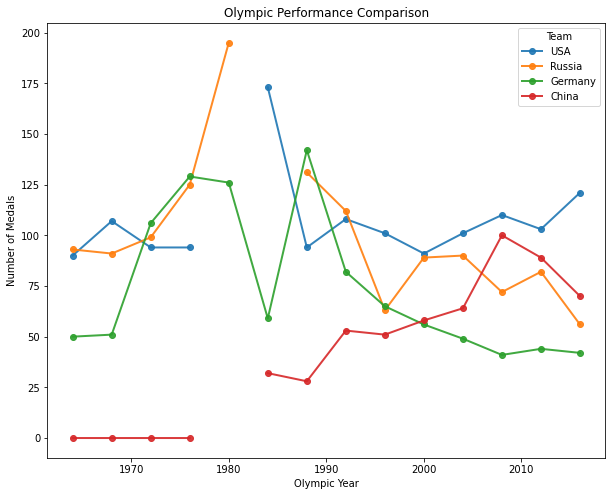

In [38]:
# List of top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

year_team_medals = pd.pivot_table(medal_tally,
                                  index = 'Year',
                                  columns = 'Team',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum')[top_countries]

# plotting the medal tallies
import matplotlib.pyplot as plt

year_team_medals.plot(linestyle = '-', marker = 'o', alpha = 0.9, figsize = (10,8), linewidth = 2)
plt.xlabel('Olympic Year')
plt.ylabel('Number of Medals')
plt.title('Olympic Performance Comparison');

1: The blank value at 1980 for USA and China is not a data error! In 1980, the United States led a boycott of the Summer Olympic Games in Moscow to protest the late 1979 Soviet invasion of Afghanistan. In total, 65 nations refused to participate in the games, whereas 80 countries sent athletes to compete, India being one of those.

2:The missing point at 1984 for Russia is no error either! The boycott of the 1984 Summer Olympics in Los Angeles followed four years after the U.S.-led boycott of the 1980 Summer Olympics in Moscow. The boycott involved 14 Eastern Bloc countries and allies, led by the Soviet Union, which initiated the boycott on May 8, 1984.

3 - China did not win in the olympics till 1984 and it has shown excellent performance since then.

Lets plot a breakdown of medal tally by the medal type - Gold, Silver, Bronze

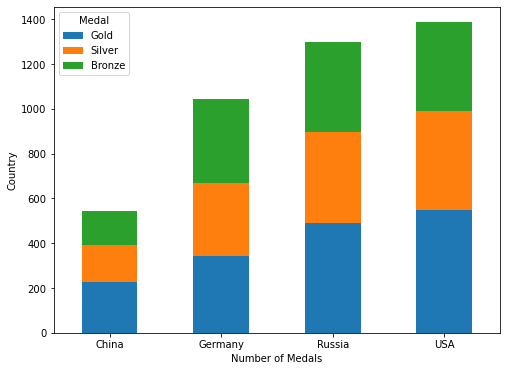

In [39]:
# List of top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

# row mask where countries match
row_mask_2 = medal_tally_agnostic['Team'].map(lambda x: x in top_countries)

# Pivot table to calculate sum of gold, silver and bronze medals for each country
medal_tally_specific = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                     index = ['Team'],
                                     columns = 'Medal',
                                     values = 'Medal_Won_Corrected',
                                     aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1)

# Re-order the columns so that they appear in order on the chart.
medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]

medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)
plt.xlabel('Number of Medals');
plt.ylabel('Country');

Countries are also in order of gold medal tallies

What sports are these countries best at?
So, what we want to find here are the events for which a country has the most proportion of gold medals from its own gold medal tally across the years.

In [40]:
# To get the sports, teams are best at, we now aggregate the medal_tally_agnostic dataframe as we did earlier.
best_team_sports = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                  index = ['Team', 'Event'],
                                  columns = 'Medal',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum',
                                  fill_value = 0).sort_values(['Team', 'Gold'], ascending = [True, False]).reset_index()

best_team_sports.drop(['Bronze', 'Silver', 'DNW'], axis = 1, inplace = True)
best_team_sports.columns = ['Team', 'Event', 'Gold_Medal_Count']

best_team_sports.groupby('Team').head(5)

,Team,Event,Gold_Medal_Count
0,China,Diving Women's Springboard,8
1,China,Table Tennis Women's Singles,8
2,China,Diving Women's Platform,7
3,China,Weightlifting Men's Lightweight,6
4,China,Badminton Women's Doubles,5
343,Germany,"Equestrianism Mixed Dressage, Team",11
344,Germany,"Canoeing Women's Kayak Doubles, 500 metres",7
345,Germany,Rowing Men's Quadruple Sculls,7
346,Germany,Rowing Women's Quadruple Sculls,6
347,Germany,Athletics Men's Discus Throw,5


Chinese are good at diving - both men and women, Germans excel at equestrian sports, Russians likes to wrestle and Americans likes to swim.

Size of Olympic contingent that these countries send to the Olympics

How do the contingents for the various countries look like? I want to know two things specifically -

The total contingent size being sent to the Olympics
The team constitution in terms of the proportion of males and females.

In [41]:
# take for each year, the team, name of the athlete and gender of the athlete and drop duplicates. These are values
# where the same athlete is taking part in more than one sport.

# get rows with top countries
row_mask_3 = olympics_complete_subset['Team'].map(lambda x: x in top_countries)

year_team_gender = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name', 'Sex']].drop_duplicates()

In [42]:
# Create a pivot table to count gender wise representation of each team in each year
year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns as per column names in the 0th level
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# rename the columns appropriately
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

In [43]:
# Separate country wise data

chi_data = year_team_gender_count[year_team_gender_count['Team'] == "China"]
chi_data.fillna(0, inplace = True)
chi_data.set_index('Year', inplace = True)

ger_data = year_team_gender_count[year_team_gender_count['Team'] == "Germany"]
ger_data.set_index('Year', inplace = True)

rus_data = year_team_gender_count[year_team_gender_count['Team'] == "Russia"]
rus_data.set_index('Year', inplace = True)

usa_data = year_team_gender_count[year_team_gender_count['Team'] == "USA"]
usa_data.set_index('Year', inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


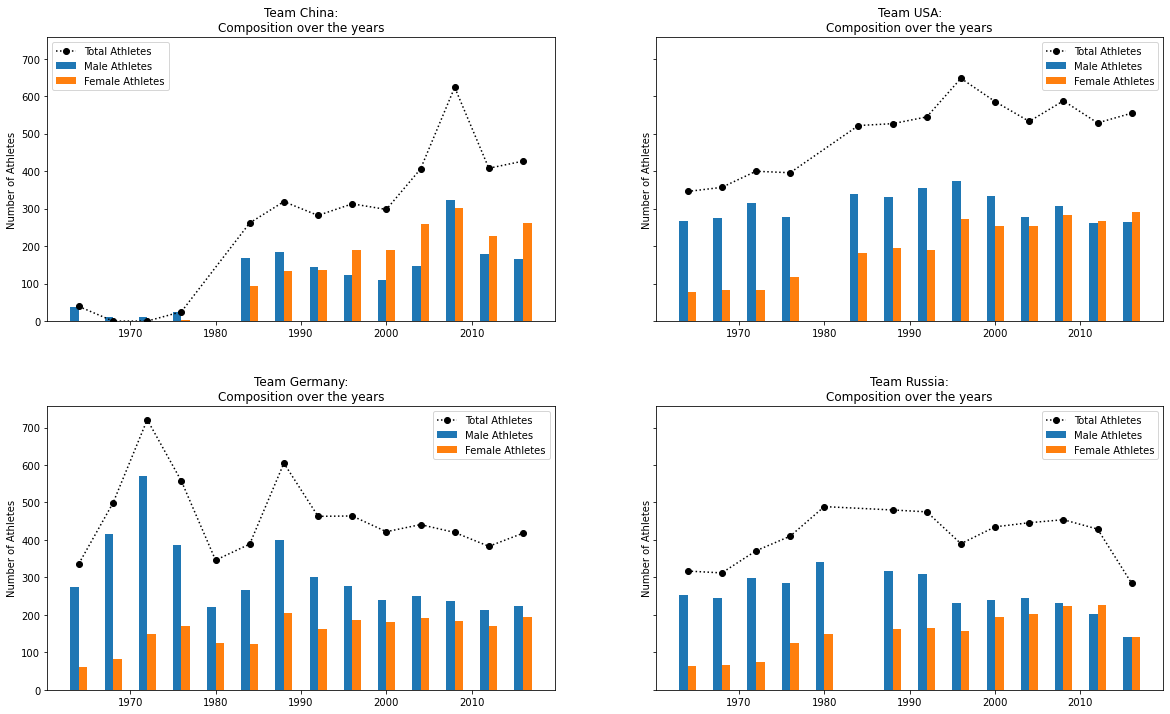

In [66]:
import seaborn as sns
# Plot the values of male, female and total athletes using bar charts and the line charts.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12), sharey = True)
fig.subplots_adjust(hspace = 0.3)

# Plot team Australia's contingent size
ax1.bar(chi_data.index.values, chi_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax1.bar(chi_data.index.values, chi_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax1.plot(chi_data.index.values, chi_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax1.set_title('Team China:\nComposition over the years')
ax1.set_ylabel('Number of Athletes')
ax1.legend(loc = 'best')

# Plot team USA's contingent size
ax2.bar(usa_data.index.values, usa_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax2.bar(usa_data.index.values, usa_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax2.plot(usa_data.index.values, usa_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax2.set_title('Team USA:\nComposition over the years')
ax2.set_ylabel('Number of Athletes')
ax2.legend(loc = 'best')

# Plot team Germany's contingent size
ax3.bar(ger_data.index.values, ger_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax3.bar(ger_data.index.values, ger_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax3.plot(ger_data.index.values, ger_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes', 
         marker = 'o')
ax3.set_title('Team Germany:\nComposition over the years')
ax3.set_ylabel('Number of Athletes')
ax3.legend(loc = 'best')

# Plot team Russia's contingent size
ax4.bar(rus_data.index.values, rus_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax4.bar(rus_data.index.values, rus_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax4.plot(rus_data.index.values, rus_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax4.set_title('Team Russia:\nComposition over the years')
ax4.set_ylabel('Number of Athletes')
ax4.legend(loc = 'best')

plt.show()

Does the size of the contingent relate with the number of medals?
To get to this, I plot the number of medals won by a team across the years with the contingent size sent to the Olympics in those years.

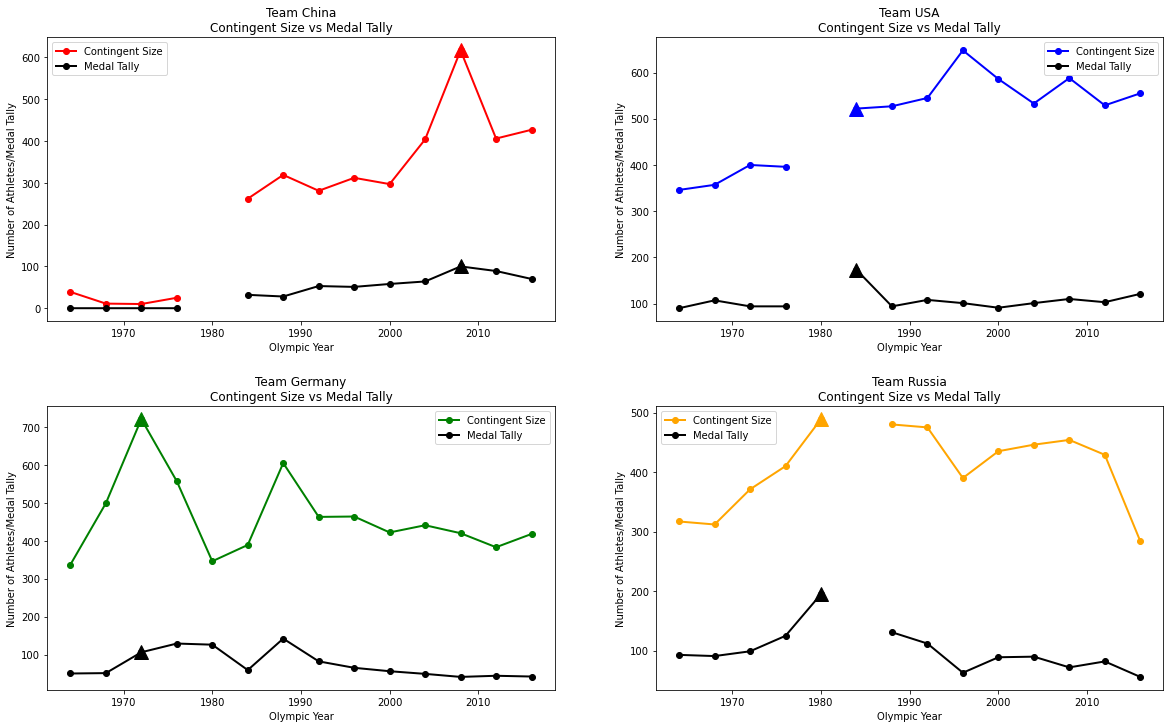

In [67]:
# Get year wise team wise athletes.
year_team_athelete = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name']].drop_duplicates()

# sum these up to get total contingent size.
contingent_size = pd.pivot_table(year_team_athelete,
                                 index = 'Year',
                                 columns = 'Team',
                                 values = 'Name',
                                 aggfunc = 'count')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2,
                                         ncols = 2,
                                        figsize = (20,12))

fig.subplots_adjust(hspace = 0.3)

# Plot australia's medal tally and contingent size
contingent_size['China'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'red', 
                                  label = 'Contingent Size')
year_team_medals['China'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                  label = 'Medal Tally')
ax1.plot(2008, contingent_size.loc[2008, 'China'], marker = '^', color = 'red', ms = 14)
ax1.plot(2008, year_team_medals.loc[2008, 'China'], marker = '^', color = 'black', ms = 14)
ax1.set_xlabel('Olympic Year')
ax1.set_ylabel('Number of Athletes/Medal Tally')
ax1.set_title('Team China\nContingent Size vs Medal Tally')
ax1.legend(loc = 'best')

# Plot USA's medal tally and contingent size
contingent_size['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'blue',
                           label = 'Contingent Size')
year_team_medals['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                            label = 'Medal Tally')
ax2.plot(1984, contingent_size.loc[1984, 'USA'], marker = '^', color = 'blue', ms = 14)
ax2.plot(1984, year_team_medals.loc[1984, 'USA'], marker = '^', color = 'black', ms = 14)
ax2.set_xlabel('Olympic Year')
ax2.set_ylabel('Number of Athletes/Medal Tally')
ax2.set_title('Team USA\nContingent Size vs Medal Tally')
ax2.legend(loc = 'best')

# Plot Germany's medal tally and contingent size
contingent_size['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'green',
                               label = 'Contingent Size')
year_team_medals['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                label = 'Medal Tally')
ax3.plot(1972, year_team_medals.loc[1972, 'Germany'], marker = '^', color = 'black', ms = 14)
ax3.plot(1972, contingent_size.loc[1972, 'Germany'], marker = '^', color = 'green', ms = 14)
ax3.set_xlabel('Olympic Year')
ax3.set_ylabel('Number of Athletes/Medal Tally')
ax3.set_title('Team Germany\nContingent Size vs Medal Tally')
ax3.legend(loc = 'best')

# Plot Russia's medal tally and contingent size
contingent_size['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'orange',
                              label = 'Contingent Size')
year_team_medals['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                               label = 'Medal Tally')
ax4.plot(1980, contingent_size.loc[1980, 'Russia'], marker = '^', color = 'orange', ms = 14)
ax4.plot(1980, year_team_medals.loc[1980, 'Russia'], marker = '^', color = 'black', ms = 14)
ax4.set_xlabel('Olympic Year')
ax4.set_ylabel('Number of Athletes/Medal Tally')
ax4.set_title('Team Russia\nContingent Size vs Medal Tally')
ax4.legend(loc = 'best')

plt.show()

It is interesting to see that for each of these countries, a point of peak in the contingent size translates directly to a peak in the medal tally! These have been marked as large triangles on the plots.

Let's now calculate the correlation coefficient between the contingent size and medal tally. We will do this for all teams and not just the top 4 to get more data and therefore, a better sense of the correlation

In [68]:
# Lets merge contingent size and medals won!
year_team_medals_unstack = year_team_medals.unstack().reset_index()
year_team_medals_unstack.columns = ['Team','Year', 'Medal_Count']

contingent_size_unstack = contingent_size.unstack().reset_index()

contingent_size_unstack.columns = ['Team','Year', 'Contingent']

contingent_medals = contingent_size_unstack.merge(year_team_medals_unstack,
                                                 left_on = ['Team', 'Year'],
                                                 right_on = ['Team', 'Year'])

contingent_medals[['Contingent', 'Medal_Count']].corr()

,Contingent,Medal_Count
Contingent,1.000000,0.703625
Medal_Count,0.703625,1.000000


The correlation matrix above confirms my conclusions from the plots! A large positive correlation (0.703) exists between contingent size and medal tally.

We'll check ahead if the edition with peak contingents of all these nations is also the edition when they were the hosts

Are there some commonalities between the countries?
Are there common sports they are all good at? The output shows the number of times a sport appears in the top 5 best sports of each country. The sport that has a number for multiple countries becomes a commonality

In [69]:
# merge best team sports with olympics data to get sport for each event.
team_commonalities = best_team_sports.merge(olympics_complete_subset.loc[:,['Sport', 'Event']].drop_duplicates(),
                                           left_on = 'Event',
                                           right_on = 'Event')

team_commonalities = team_commonalities.sort_values(['Team', 'Gold_Medal_Count'], ascending = [True, False])
team_commonalities = team_commonalities.groupby('Team').head(5).reset_index()

# make a pivot table of the commonalities.
pd.pivot_table(team_commonalities,
              index = 'Sport',
              columns = 'Team',
              values = 'Event',
              aggfunc = 'count',
              fill_value = 0,
              margins = True).sort_values('All', ascending = False)[1:]

Team,China,Germany,Russia,USA,All
Sport,,,,,
Athletics,0,1,0,2,3
Diving,2,0,0,0,2
Rowing,0,2,0,0,2
Swimming,0,0,0,2,2
Wrestling,0,0,2,0,2
Badminton,1,0,0,0,1
Basketball,0,0,0,1,1
Canoeing,0,1,0,0,1
Equestrianism,0,1,0,0,1


There is very little in common between these countries. It is perhaps why these are all at the top. Each competes and wins in its own area of expertise.

Do teams enjoy a home advantage?
A home advantage is a phenomenon where a team does better when the olympics are being held in its own country than it fares in other countries. To keep the comparison fair, we would compare the performance of these teams in the year when the olympics was held at their home vs one edition earlier and one edition later.

### Where was the olympics held in each of the years under consideration?

In [70]:
olympics_complete_subset[['Year', 'City']].drop_duplicates().sort_values('Year')

,Year,City
74,1964,Tokyo
11,1968,Mexico City
12,1972,Munich
37,1976,Montreal
70,1980,Moscow
10,1984,Los Angeles
13,1988,Seoul
0,1992,Barcelona
3,1996,Atlanta
2,2000,Sydney


cities have been captured incorrectly-

Moskva should be 'Moscow'
Athina should be 'Athens'
These are Russian and Greek variants
Let's first correct these cities before we proceed with any analysis

In [71]:
# Correct city names in the dataset
olympics_complete_subset['City'].replace(['Athina', 'Moskva'], ['Athens', 'Moscow'], inplace = True)

In [72]:
olympics_complete_subset[['Year', 'City']].drop_duplicates().sort_values('Year')

,Year,City
74,1964,Tokyo
11,1968,Mexico City
12,1972,Munich
37,1976,Montreal
70,1980,Moscow
10,1984,Los Angeles
13,1988,Seoul
0,1992,Barcelona
3,1996,Atlanta
2,2000,Sydney


Names corrected, let's map each of these cities to their countries.

In [73]:
# city to country mapping dictionary
city_to_country = {'Tokyo': 'Japan',
                  'Mexico City': 'Mexico',
                  'Munich': 'Germany',
                  'Montreal': 'Canada',
                  'Moscow': 'Russia',
                  'Los Angeles': 'USA',
                  'Seoul': 'South Korea',
                  'Barcelona': 'Spain',
                  'Atlanta': 'USA',
                  'Sydney': 'Australia',
                  'Athens': 'Greece',
                  'Beijing': 'China',
                  'London': 'UK',
                  'Rio de Janeiro': 'Brazil'}

# Map cities to countries
olympics_complete_subset['Country_Host'] = olympics_complete_subset['City'].map(city_to_country)

#print the 
olympics_complete_subset.loc[:, ['Year', 'Country_Host']].drop_duplicates().sort_values('Year')

,Year,Country_Host
74,1964,Japan
11,1968,Mexico
12,1972,Germany
37,1976,Canada
70,1980,Russia
10,1984,USA
13,1988,South Korea
0,1992,Spain
3,1996,USA
2,2000,Australia


Each of our top countries has at least one instance of hosting in the considered time period.

One problem though, is that Russia hosted in a year when USA did NOT participate. Since Russia and USA were the top contenders for medals in the period, it should be that Russia won a lot more than they would have in case USA participated. We would ideally need to control for this!

The approach for home advantage calculation would be to list host country against each year, playing nation and their total medal tally. Then we would compare performance one edition before and one edition after the olympics was held at that playing country's home.

In [74]:
# Extract year, host nation and team name from the data
year_host_team = olympics_complete_subset[['Year', 'Country_Host', 'Team']].drop_duplicates()

# check rows where host country is the same as team
row_mask_4 = (year_host_team['Country_Host'] == year_host_team['Team'])

# add years in the year_host_team to capture one previous and one later year
year_host_team['Prev_Year'] = year_host_team['Year'] - 4
year_host_team['Next_Year'] = year_host_team['Year'] + 4

# Subset only where host nation and team were the same
year_host_team = year_host_team[row_mask_4]

# Calculate the medals won in each year where a team played at home. merge year_host_team with medal_tally on year and team
year_host_team_medal = year_host_team.merge(medal_tally,
                                           left_on = ['Year', 'Team'],
                                           right_on = ['Year', 'Team'],
                                           how = 'left')

year_host_team_medal.rename(columns = {'Medal_Won_Corrected' : 'Medal_Won_Host_Year'}, inplace = True)

# Calculate medals won by team in previous year
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Prev_Year', 'Team'],
                                                 right_on = ['Year', 'Team'],
                                                 how = 'left')

year_host_team_medal.drop('Year_y', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Medal_Won_Corrected': 'Medal_Won_Prev_Year',
                                      'Year_x':'Year'}, inplace = True)

# Calculate the medals won by the team the year after they hosted.
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Next_Year', 'Team'],
                                                 right_on = ['Year', 'Team'],
                                                 how = 'left')

year_host_team_medal.drop('Year_y', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Year_x': 'Year',
                                      'Medal_Won_Corrected' : 'Medal_Won_Next_Year'}, inplace = True)

# General formatting changes
year_host_team_medal.drop(['Prev_Year', 'Next_Year'], axis = 1, inplace = True)
year_host_team_medal.sort_values('Year', ascending = True, inplace = True)
year_host_team_medal.reset_index(inplace = True, drop = True)

# column re-ordering
year_host_team_medal = year_host_team_medal.loc[:, ['Year', 'Country_Host', 'Team', 'Medal_Won_Prev_Year', 'Medal_Won_Host_Year', 'Medal_Won_Next_Year']]

year_host_team_medal

,Year,Country_Host,Team,Medal_Won_Prev_Year,Medal_Won_Host_Year,Medal_Won_Next_Year
0,1964,Japan,Japan,NaN,29.0,25.0
1,1968,Mexico,Mexico,1.0,9.0,1.0
2,1972,Germany,Germany,51.0,106.0,129.0
3,1976,Canada,Canada,5.0,11.0,NaN
4,1980,Russia,Russia,125.0,195.0,NaN
5,1984,USA,USA,NaN,173.0,94.0
6,1988,South Korea,South Korea,19.0,33.0,28.0
7,1992,Spain,Spain,4.0,22.0,17.0
8,1996,USA,USA,108.0,101.0,91.0
9,2000,Australia,Australia,41.0,58.0,50.0


Excluding rows with Russia (1980) and USA (1984) because their biggest contender didn't participate in the olympics that time, we see that in general team do better whilst playing at home.

Does GDP play a part in medal tallies?
GDP is a proxy for a country's resources. A higher GDP means more resources to allocate to sports!

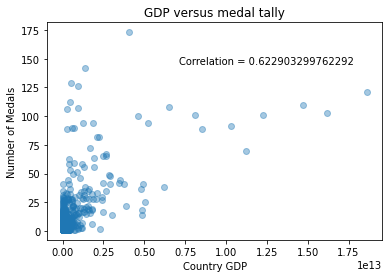

In [75]:
year_team_gdp = olympics_complete_subset.loc[:, ['Year', 'Team', 'GDP']].drop_duplicates()

medal_tally_gdp = medal_tally.merge(year_team_gdp,
                                   left_on = ['Year', 'Team'],
                                   right_on = ['Year', 'Team'],
                                   how = 'left')

row_mask_5 = medal_tally_gdp['Medal_Won_Corrected'] > 0
row_mask_6 = medal_tally_gdp['Team'].map(lambda x: x in top_countries)

correlation = medal_tally_gdp.loc[row_mask_5, ['GDP', 'Medal_Won_Corrected']].corr()['Medal_Won_Corrected'][0]

plt.plot(medal_tally_gdp.loc[row_mask_5, 'GDP'], 
     medal_tally_gdp.loc[row_mask_5, 'Medal_Won_Corrected'] , 
     linestyle = 'none', 
     marker = 'o',
    alpha = 0.4)
plt.xlabel('Country GDP')

plt.ylabel('Number of Medals')
plt.title('GDP versus medal tally')
plt.text(np.nanpercentile(medal_tally_gdp['GDP'], 99.6), 
     max(medal_tally_gdp['Medal_Won_Corrected']) - 50,
     "Correlation = " + str(correlation));

The plot shows a 0.622 correlation between GDP and medals won! Thats a significant correlation. So GDP positively impacts the number of medals won by a team.

Who are the most accomplished athletes in each sport?
Lets define accomplished athletes as those with a high medal to participation ratio. This means the average number of medals they win with each participation. Participation would be counted as the number of events that they participated in.

In [76]:
# lets create a data frame of athletes with the sport they participated in and the number of medals won.
ath_sport_medal = olympics_complete_subset.groupby(['Team','Name', 'Sport'])['Medal_Won'].agg('sum').reset_index()
ath_sport_medal.sort_values(['Sport', 'Medal_Won'], ascending = [True, False], inplace = True)

# keep only athletes who won medals
medal_mask = ath_sport_medal['Medal_Won'] > 0
ath_sport_medal = ath_sport_medal[medal_mask]

ath_sport_medal.head()

,Team,Name,Sport,Medal_Won
66110,South Korea,Kim Su-Nyeong,Archery,6
65767,South Korea,Ki Bo-Bae,Archery,4
66718,South Korea,Park Seong-Hyeon,Archery,4
16642,China,Zhang Juanjuan,Archery,3
39055,Italy,Marco Galiazzo,Archery,3


In [77]:
# Now lets calculate the number of participations of each athlete. This will be sport wise.
ath_sport_appearance = olympics_complete_subset.groupby(['Team', 'Name', 'Sport'])['NOC'].agg('count').reset_index()

ath_sport_appearance.rename(columns = {'NOC': 'Event_Count'}, inplace = True)

ath_sport_appearance.head()

# lets merge these two.
ath_medal_appearance = ath_sport_medal.merge(ath_sport_appearance,
                                            left_on = ["Team", "Name", "Sport"],
                                            right_on = ['Team', 'Name', 'Sport'],
                                            how = "left")

# Calculate the medal per participation
ath_medal_appearance['Medal_Per_Participation'] = ath_medal_appearance['Medal_Won']/ath_medal_appearance['Event_Count']

ath_medal_appearance.sort_values(['Medal_Per_Participation', 'Medal_Won'], ascending = [False, False], inplace = True)

ath_medal_appearance.head(10)

,Team,Name,Sport,Medal_Won,Event_Count,Medal_Per_Participation
12179,USA,Natalie Anne Coughlin (-Hall),Swimming,12,12,1.0
150,USA,"Frederick Carlton ""Carl"" Lewis",Athletics,10,10,1.0
4925,Germany,Isabelle Regina Werth,Equestrianism,10,10,1.0
12184,USA,"Gary Wayne Hall, Jr.",Swimming,10,10,1.0
5296,Italy,Maria Valentina Vezzali,Fencing,9,9,1.0
12191,Germany,"Kornelia Ender (-Matthes, -Grummt)",Swimming,8,8,1.0
12195,USA,"Donald Arthur ""Don"" Schollander",Swimming,8,8,1.0
12197,USA,Nathan Ghar-Jun Adrian,Swimming,8,8,1.0
4191,UK,Jason Francis Kenny,Cycling,7,7,1.0
4745,China,Wu Minxia,Diving,7,7,1.0


We see a lot of athletes with below 10 medals but a medal every time they participate. Let's filter only those that have more than 10 medals.

In [78]:
# filter out athletes with less than 10 total medals.
ath_medal_appearance = ath_medal_appearance[ath_medal_appearance['Medal_Won'] >= 10]

ath_medal_appearance

,Team,Name,Sport,Medal_Won,Event_Count,Medal_Per_Participation
12179,USA,Natalie Anne Coughlin (-Hall),Swimming,12,12,1.000000
150,USA,"Frederick Carlton ""Carl"" Lewis",Athletics,10,10,1.000000
4925,Germany,Isabelle Regina Werth,Equestrianism,10,10,1.000000
12184,USA,"Gary Wayne Hall, Jr.",Swimming,10,10,1.000000
12176,USA,"Michael Fred Phelps, II",Swimming,28,30,0.933333
3614,Germany,Birgit Fischer-Schmidt,Canoeing,12,13,0.923077
12177,USA,"Dara Grace Torres (-Hoffman, -Minas)",Swimming,12,13,0.923077
12181,USA,Mark Andrew Spitz,Swimming,11,12,0.916667
12182,USA,"Matthew Nicholas ""Matt"" Biondi",Swimming,11,12,0.916667
12180,USA,Ryan Steven Lochte,Swimming,12,14,0.857143


We see that 9 out of 18 athletes in this list are from the United States of America and 8 of those are champion swimmers!

After the exploration, a lot of different questions come to mind. Can we predict the medal tally of a country? Is there some correlation between the age, height or weight of athletes in a sport? Lets try to answer these using machine learning techniques!

Can we predict the medal tally of a country?
The exploration phase showed that the following factors affect a country's medal tally -

GDP
Contingent Size
Population
Home field advantage

In [79]:
# create the year, team contingent size
year_team_gender = olympics_complete_subset.loc[:,['Year','Team', 'Name', 'Sex']].drop_duplicates()

year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns as per column names in the 0th level
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# rename the columns appropriately
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']
year_team_gender_count = year_team_gender_count.fillna(0)

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

year_team_contingent = year_team_gender_count.loc[:, ['Year', 'Team','Total_Athletes']]
year_team_contingent.head()

,Year,Team,Total_Athletes
0,1964,Afghanistan,8.0
1,1964,Algeria,1.0
2,1964,Argentina,102.0
3,1964,Australia,243.0
4,1964,Austria,56.0


In [80]:
# get year, team and GDP - medal_tally_gdp has it
medal_tally_gdp.head()

,Year,Team,Medal_Won_Corrected,GDP
0,1964,Afghanistan,0.0,8.000000e+08
1,1964,Algeria,0.0,2.909352e+09
2,1964,Argentina,1.0,2.560525e+10
3,1964,Australia,18.0,2.378766e+10
4,1964,Austria,0.0,9.169984e+09


In [81]:
# Get year team population
year_team_pop = olympics_complete_subset.loc[:, ['Year', 'Team', 'Population']].drop_duplicates()
year_team_pop.head()

,Year,Team,Population
0,1992,China,1.164970e+09
1,2012,China,1.350695e+09
2,2000,Finland,5.176209e+06
3,1996,Finland,5.124573e+06
6,2008,Norway,4.768212e+06


In [82]:
# merge all these datasets together
medal_gdp_population = medal_tally_gdp.merge(year_team_pop,
                                            left_on = ['Year', 'Team'],
                                            right_on = ['Year', 'Team'],
                                            how = 'left')

medal_gdp_pop_contingent = medal_gdp_population.merge(year_team_contingent,
                                                     left_on = ['Year', 'Team'],
                                                     right_on = ['Year', 'Team'],
                                                     how = 'left')
medal_gdp_pop_contingent.head()


,Year,Team,Medal_Won_Corrected,GDP,Population,Total_Athletes
0,1964,Afghanistan,0.0,8.000000e+08,9731361.0,8.0
1,1964,Algeria,0.0,2.909352e+09,12295970.0,1.0
2,1964,Argentina,1.0,2.560525e+10,21953929.0,102.0
3,1964,Australia,18.0,2.378766e+10,11167000.0,243.0
4,1964,Austria,0.0,9.169984e+09,7223801.0,56.0


In [83]:
# get host nation from the data
year_host = olympics_complete_subset.loc[:, ['Year', 'Country_Host']].drop_duplicates()

# merge this with the larger dataset
lin_model_data = medal_gdp_pop_contingent.merge(year_host,
                              left_on = 'Year',
                              right_on = 'Year',
                              how = 'left')

lin_model_data.head()

,Year,Team,Medal_Won_Corrected,GDP,Population,Total_Athletes,Country_Host
0,1964,Afghanistan,0.0,8.000000e+08,9731361.0,8.0,Japan
1,1964,Algeria,0.0,2.909352e+09,12295970.0,1.0,Japan
2,1964,Argentina,1.0,2.560525e+10,21953929.0,102.0,Japan
3,1964,Australia,18.0,2.378766e+10,11167000.0,243.0,Japan
4,1964,Austria,0.0,9.169984e+09,7223801.0,56.0,Japan


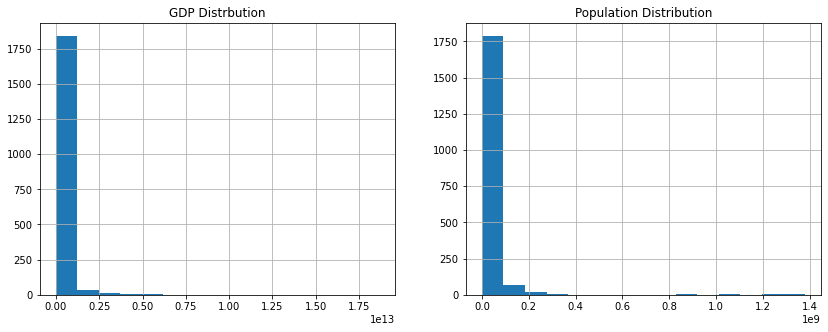

In [84]:
# Regression model
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import metrics

# add indicator to see whether home advantage
lin_model_data['Home_adv'] = np.where(lin_model_data['Country_Host'] == lin_model_data['Team'], 1, 0)

# Add per capita GDP
lin_model_data['GDP_per_capita'] = lin_model_data['GDP']/lin_model_data['Population']

# remove NAs
lin_model_data.dropna(how = 'any', inplace = True)


# Lets see the distrbution of population and GDP in a histogram

fig, (ax1, ax2) = plt.subplots(nrows = 1,
                          ncols = 2,
                          figsize = (14,5))

lin_model_data['GDP'].hist(bins = 15, ax = ax1)
ax1.set_title('GDP Distrbution')

lin_model_data['Population'].hist(bins = 15, ax = ax2)
ax2.set_title('Population Distribution');

The charts show that these variables are highly skewed. It would do better to do a logarithmic transform of these for better fit in the linear model.

In [85]:
import math

# take the log transforms for the variables
lin_model_data['Log_Population'] = np.log(lin_model_data['Population'])
lin_model_data['Log_GDP'] = np.log(lin_model_data['GDP'])

In [86]:
# regression model
y, X = dmatrices('Medal_Won_Corrected ~ Log_GDP + Log_Population + Total_Athletes + Home_adv + GDP_per_capita', 
                data = lin_model_data,
                return_type = 'dataframe')

model = sm.OLS(y, X)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Medal_Won_Corrected   R-squared:                       0.755
Model:                             OLS   Adj. R-squared:                  0.754
Method:                  Least Squares   F-statistic:                     1170.
Date:                 Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                         16:07:57   Log-Likelihood:                -6455.3
No. Observations:                 1907   AIC:                         1.292e+04
Df Residuals:                     1901   BIC:                         1.296e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         16.6564      2.214      7.525      0.000      12.315      20.998
Log_GDP           -1.1254      0.161     -7.009      0.000      -1.440      -0.811
Log_Population     0.3971      0.155      2.562      0.010       0.093       0.701
Total_Athletes     0.1462      0.002     58.549      0.000       0.141       0.151
Home_adv          -7.9921      2.180     -3.665      0.000     -12.269      -3.716
GDP_per_capita  1.344e-05   1.48e-05      0.907      0.365   -1.56e-05    4.25e-05
==============================================================================
Omnibus:                     1859.147   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           253485.577
Skew:                           4.229   Prob(JB):                         0.00
Kurtosis:                      58.845   Cond. No.                     2.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The result summary above shows an R^2 value of 0.75 which is good. This means that these variables account for 75% of all variation in the medal tally.

75% is a good R^2, but what matters more is the amount of error we get when predicting the medal tally of a country - It should not be too large. The RMSE error on the predictions is shown below -

In [87]:
# what is the error associated with this prediction?
y_predicted = result.predict(X)
np.sqrt(metrics.mean_squared_error(y, y_predicted))

7.142700384582237

The above result shows that if these predictors are known, we can predict the medal tally of a country with an error of just ~7 medals! Thats good!

Can we predict the sport an athlete plays using just height and weight?

In [88]:
# How many unique sports are there?
olympics_complete_subset['Sport'].unique()

array(['Basketball', 'Judo', 'Badminton', 'Sailing', 'Athletics',
       'Handball', 'Weightlifting', 'Wrestling', 'Water Polo', 'Hockey',
       'Rowing', 'Swimming', 'Football', 'Equestrianism', 'Boxing',
       'Gymnastics', 'Taekwondo', 'Fencing', 'Diving', 'Canoeing',
       'Tennis', 'Shooting', 'Cycling', 'Softball', 'Archery',
       'Volleyball', 'Synchronized Swimming', 'Modern Pentathlon',
       'Table Tennis', 'Baseball', 'Rhythmic Gymnastics', 'Rugby Sevens',
       'Trampolining', 'Beach Volleyball', 'Triathlon', 'Golf'],
      dtype=object)

In [95]:
from sklearn.linear_model import LogisticRegression

In [104]:
import statsmodels.formula.api as sm

In [105]:
X=pd.get_dummies(lin_model_data.GDP,drop_first=True)
y=np.asarray(lin_model_data.Medal_Won_Corrected)

In [111]:
for i,j in np.array(model.params.reset_index()):
    print('({}) * {} +'.format(round(j,2),i),end=' ')

(16.66) * Intercept + (-1.13) * Log_GDP + (0.4) * Log_Population + (0.15) * Total_Athletes + (-7.99) * Home_adv + (0.0) * GDP_per_capita + 

In [ ]:
#Will try a different but simpler approach